##  **Libraries** 

In this section, I define all the libraries required throughout the scope of this project.


In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import re
import sys
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    roc_curve,
    auc, 
    precision_recall_curve,
    confusion_matrix, 
    ConfusionMatrixDisplay
)

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

import shap

print("Kernel Python:", sys.executable)

Kernel Python: /Users/saadahsan/Downloads/dissertation/nhs_env/bin/python


### **Run if your environment doesnt have these Installed**

In [123]:
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install shap

You should consider upgrading via the '/Users/saadahsan/Downloads/dissertation/nhs_env/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/saadahsan/Downloads/dissertation/nhs_env/bin/python -m pip install --upgrade pip' command.


### **Project Setup and Data Directory**

In this section, I define the base project directory and the `data/` folder,
then list all available CSV files. This ensures that:

- The paths are consistent and reusable across the notebook.
- All Referral-to-Treatment (RTT) monthly CSV files are visible and can be loaded in bulk.

This also makes the notebook portable: as long as the `NHS_RTT_Project/data` folder
exists with the required files, all subsequent steps will run.

In [124]:
BASE_DIR = Path("./NHS_RTT_Project").resolve()
DATA_DIR = BASE_DIR / 'data'

print("Base directory:", BASE_DIR)
print("Data directory:", DATA_DIR)

list(DATA_DIR.glob('*.csv'))

Base directory: /Users/saadahsan/Downloads/dissertation/NHS_RTT_Project
Data directory: /Users/saadahsan/Downloads/dissertation/NHS_RTT_Project/data


[PosixPath('/Users/saadahsan/Downloads/dissertation/NHS_RTT_Project/data/RTT-December-2023-full-extract-revised.csv'),
 PosixPath('/Users/saadahsan/Downloads/dissertation/NHS_RTT_Project/data/RTT-April-2023-full-extract.csv'),
 PosixPath('/Users/saadahsan/Downloads/dissertation/NHS_RTT_Project/data/RTT-March-2024-full-extract-revised.csv'),
 PosixPath('/Users/saadahsan/Downloads/dissertation/NHS_RTT_Project/data/RTT-February-2024-full-extract-revised.csv'),
 PosixPath('/Users/saadahsan/Downloads/dissertation/NHS_RTT_Project/data/epraccur.csv'),
 PosixPath('/Users/saadahsan/Downloads/dissertation/NHS_RTT_Project/data/RTT-September-2023-full-extract-revised.csv'),
 PosixPath('/Users/saadahsan/Downloads/dissertation/NHS_RTT_Project/data/RTT-January-2024-full-extract-revised.csv'),
 PosixPath('/Users/saadahsan/Downloads/dissertation/NHS_RTT_Project/data/Index_of_Multiple_Deprivation_(Dec_2019)_Lookup_in_England.csv'),
 PosixPath('/Users/saadahsan/Downloads/dissertation/NHS_RTT_Project/data

### **Loading RTT Waiting-Time Data (Incomplete Pathways Only)**

Here I:

1. Load **all RTT monthly CSV files** from April 2023 to March 2024.
2. Concatenate them into a single DataFrame (`rtt_raw`).
3. Filter to **"Incomplete Pathways"**, i.e. patients who are still waiting to start treatment.
4. Compute:
   - `Over18Weeks`: number of patients waiting ≥ 18 weeks
   - `PropOver18`: proportion of the waiting list breaching 18 weeks
   - `Exceeded18`: binary flag indicating if the 18-week target is exceeded (e.g. >10% of patients)

This will later become the core target for both **classification** (Exceeded18) and
**regression** (PropOver18).

In [125]:
csv_files = sorted(DATA_DIR.glob('*.csv'))
print("Found", len(csv_files), "CSV files.")

dfs = []
for f in csv_files:
    print("Reading:", f.name)
    df = pd.read_csv(f, dtype=str)  
    df['SourceFile'] = f.name       
    dfs.append(df)

rtt_raw = pd.concat(dfs, ignore_index=True)
print("Combined shape:", rtt_raw.shape)

rtt_raw.head()


Found 15 CSV files.
Reading: Index_of_Multiple_Deprivation_(Dec_2019)_Lookup_in_England.csv
Reading: RTT-April-2023-full-extract.csv
Reading: RTT-August-2023-full-extract-revised.csv
Reading: RTT-December-2023-full-extract-revised.csv
Reading: RTT-February-2024-full-extract-revised.csv
Reading: RTT-January-2024-full-extract-revised.csv
Reading: RTT-July-2023-full-extract-revised.csv
Reading: RTT-June-2023-full-extract.csv
Reading: RTT-March-2024-full-extract-revised.csv
Reading: RTT-May-2023-full-extract-revised.csv
Reading: RTT-November-2023-full-extract-revised.csv
Reading: RTT-October-2023-full-extract-revised.csv
Reading: RTT-September-2023-full-extract-revised.csv
Reading: epraccur.csv
Reading: rtt_hes_lag_df_2023_24.csv
Combined shape: (3034085, 178)


,FID,LSOA11CD,LSOA11NM,LAD19CD,LAD19NM,IMD19,SourceFile,Period,Provider Parent Org Code,Provider Parent Name,...,FCE_BedDays,Period_clean,Year,Month,Month_Name,Prev_PropOver18,Prev_Over18Weeks,Prev_Total_All,Prev_MeanWait_Days,Prev_MeanLOS_Days
0,1,E01000001,City of London 001A,E09000001,City of London,29199,Index_of_Multiple_Deprivation_(Dec_2019)_Looku...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,E01000104,Barking and Dagenham 014B,E09000002,Barking and Dagenham,6002,Index_of_Multiple_Deprivation_(Dec_2019)_Looku...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,E01000205,Barnet 035A,E09000003,Barnet,27397,Index_of_Multiple_Deprivation_(Dec_2019)_Looku...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,E01000002,City of London 001B,E09000001,City of London,30379,Index_of_Multiple_Deprivation_(Dec_2019)_Looku...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,E01000003,City of London 001C,E09000001,City of London,14915,Index_of_Multiple_Deprivation_(Dec_2019)_Looku...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **Applying Filter for incomplete Pathways only**

In [126]:
rtt_inc = rtt_raw[rtt_raw['RTT Part Description'] == 'Incomplete Pathways'].copy()
print("After filtering to Incomplete Pathways:", rtt_inc.shape)
rtt_inc.head()


After filtering to Incomplete Pathways: (797967, 178)


,FID,LSOA11CD,LSOA11NM,LAD19CD,LAD19NM,IMD19,SourceFile,Period,Provider Parent Org Code,Provider Parent Name,...,FCE_BedDays,Period_clean,Year,Month,Month_Name,Prev_PropOver18,Prev_Over18Weeks,Prev_Total_All,Prev_MeanWait_Days,Prev_MeanLOS_Days
32851,NaN,NaN,NaN,NaN,NaN,NaN,RTT-April-2023-full-extract.csv,RTT-April-2023,QE1,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32852,NaN,NaN,NaN,NaN,NaN,NaN,RTT-April-2023-full-extract.csv,RTT-April-2023,QE1,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32853,NaN,NaN,NaN,NaN,NaN,NaN,RTT-April-2023-full-extract.csv,RTT-April-2023,QE1,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32854,NaN,NaN,NaN,NaN,NaN,NaN,RTT-April-2023-full-extract.csv,RTT-April-2023,QE1,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32855,NaN,NaN,NaN,NaN,NaN,NaN,RTT-April-2023-full-extract.csv,RTT-April-2023,QE1,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [189]:
cols_to_show = ["Period","Provider Org Code","Provider Org Name","Treatment Function Code","Treatment Function Name"]


rtt_inc[cols_to_show].head(20)

,Period,Provider Org Code,Provider Org Name,Treatment Function Code,Treatment Function Name
32851,RTT-April-2023,A4M8P,BUCKSHAW HOSPITAL,C_100,General Surgery Service
32852,RTT-April-2023,A4M8P,BUCKSHAW HOSPITAL,C_101,Urology Service
32853,RTT-April-2023,A4M8P,BUCKSHAW HOSPITAL,C_110,Trauma and Orthopaedic Service
32854,RTT-April-2023,A4M8P,BUCKSHAW HOSPITAL,C_120,Ear Nose and Throat Service
32855,RTT-April-2023,A4M8P,BUCKSHAW HOSPITAL,C_502,Gynaecology Service
32856,RTT-April-2023,A4M8P,BUCKSHAW HOSPITAL,X06,Other - Other Services
32857,RTT-April-2023,A4M8P,BUCKSHAW HOSPITAL,C_999,Total
32870,RTT-April-2023,A4M8P,BUCKSHAW HOSPITAL,C_100,General Surgery Service
32871,RTT-April-2023,A4M8P,BUCKSHAW HOSPITAL,C_101,Urology Service
32872,RTT-April-2023,A4M8P,BUCKSHAW HOSPITAL,C_110,Trauma and Orthopaedic Service


#### **Total Week-Band columns present in the dataset**

In [127]:
week_cols = [c for c in rtt_inc.columns if c.startswith('Gt') and c.endswith('SUM 1')]
print("Number of week-band columns:", len(week_cols))
week_cols[:10], "...", week_cols[-10:]


Number of week-band columns: 105


(['Gt 00 To 01 Weeks SUM 1',
  'Gt 01 To 02 Weeks SUM 1',
  'Gt 02 To 03 Weeks SUM 1',
  'Gt 03 To 04 Weeks SUM 1',
  'Gt 04 To 05 Weeks SUM 1',
  'Gt 05 To 06 Weeks SUM 1',
  'Gt 06 To 07 Weeks SUM 1',
  'Gt 07 To 08 Weeks SUM 1',
  'Gt 08 To 09 Weeks SUM 1',
  'Gt 09 To 10 Weeks SUM 1'],
 '...',
 ['Gt 95 To 96 Weeks SUM 1',
  'Gt 96 To 97 Weeks SUM 1',
  'Gt 97 To 98 Weeks SUM 1',
  'Gt 98 To 99 Weeks SUM 1',
  'Gt 99 To 100 Weeks SUM 1',
  'Gt 100 To 101 Weeks SUM 1',
  'Gt 101 To 102 Weeks SUM 1',
  'Gt 102 To 103 Weeks SUM 1',
  'Gt 103 To 104 Weeks SUM 1',
  'Gt 104 Weeks SUM 1'])

#### **Get Treatment Columns greater than 18 Weeks**

In [128]:
def extract_start_week(colname):
    num = re.findall(r'\d+', colname)
    return int(num[0]) if num else None

week_cols_18plus = [c for c in week_cols if extract_start_week(c) >= 18]
print("Week columns >= 18 weeks:", len(week_cols_18plus))
week_cols_18plus[:5], "...", week_cols_18plus[-5:]


Week columns >= 18 weeks: 87


(['Gt 18 To 19 Weeks SUM 1',
  'Gt 19 To 20 Weeks SUM 1',
  'Gt 20 To 21 Weeks SUM 1',
  'Gt 21 To 22 Weeks SUM 1',
  'Gt 22 To 23 Weeks SUM 1'],
 '...',
 ['Gt 100 To 101 Weeks SUM 1',
  'Gt 101 To 102 Weeks SUM 1',
  'Gt 102 To 103 Weeks SUM 1',
  'Gt 103 To 104 Weeks SUM 1',
  'Gt 104 Weeks SUM 1'])

### **Deriving 18-Week Breach Indicators from Incomplete RTT Pathways**

Here I:

1. Convert all waiting-time columns corresponding to **18 weeks and above** into numeric format, ensuring that any invalid or missing entries do not affect aggregation.
2. Convert the total count of incomplete RTT pathways into a numeric variable to provide a valid denominator for proportional analysis.
3. Compute:
   - `Over18Weeks`: the total number of patients whose waiting time exceeds the NHS 18-week standard, obtained by summing all ≥18-week bands.
   - `PropOver18`: the proportion of incomplete pathways breaching the 18-week target, calculated by normalising `Over18Weeks` by the total waiting list.
4. Clean edge cases by replacing infinite and missing values with zero, ensuring numerical stability and interpretability.

These derived indicators provide a robust and standardised measure of long-waiting patients and form a key input for downstream **performance analysis, modelling, and visualisation**.

In [129]:
for c in week_cols_18plus:
    rtt_inc[c] = pd.to_numeric(rtt_inc[c], errors='coerce')
rtt_inc['Total_All'] = pd.to_numeric(rtt_inc['Total All'], errors='coerce')

rtt_inc['Over18Weeks'] = rtt_inc[week_cols_18plus].sum(axis=1)

rtt_inc['PropOver18'] = rtt_inc['Over18Weeks'] / rtt_inc['Total_All']

rtt_inc['PropOver18'] = rtt_inc['PropOver18'].replace([float('inf'), -float('inf')], 0)
rtt_inc['PropOver18'] = rtt_inc['PropOver18'].fillna(0)

rtt_inc[['Over18Weeks','PropOver18']].head()

,Over18Weeks,PropOver18
32851,25.0,0.416667
32852,5.0,0.357143
32853,3.0,0.600000
32854,8.0,0.470588
32855,7.0,0.700000


In [186]:
rtt_inc['Exceeded18'] = (rtt_inc['PropOver18'] > 0.10).astype(int)
print(rtt_inc['Exceeded18'].value_counts())
rtt_inc.head()



Exceeded18
1    534550
0    263417
Name: count, dtype: int64


,FID,LSOA11CD,LSOA11NM,LAD19CD,LAD19NM,IMD19,SourceFile,Period,Provider Parent Org Code,Provider Parent Name,...,FCE_BedDays,Period_clean,Year,Month,Month_Name,Prev_PropOver18,Prev_Over18Weeks,Prev_Total_All,Prev_MeanWait_Days,Prev_MeanLOS_Days
32851,NaN,NaN,NaN,NaN,NaN,NaN,RTT-April-2023-full-extract.csv,RTT-April-2023,QE1,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32852,NaN,NaN,NaN,NaN,NaN,NaN,RTT-April-2023-full-extract.csv,RTT-April-2023,QE1,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32853,NaN,NaN,NaN,NaN,NaN,NaN,RTT-April-2023-full-extract.csv,RTT-April-2023,QE1,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32854,NaN,NaN,NaN,NaN,NaN,NaN,RTT-April-2023-full-extract.csv,RTT-April-2023,QE1,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32855,NaN,NaN,NaN,NaN,NaN,NaN,RTT-April-2023-full-extract.csv,RTT-April-2023,QE1,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **Loading and Cleaning HES 2023–24 Provider-Level Data**

In this section I load the **HES Admitted Patient Care 2023–24** Excel file and:

- Detect the correct header row (since the NHS table has title rows above the header).
- Extract:
  - `Provider Org Code` (trust code)
  - `Provider Org Name` (trust name)
  - Key activity variables (FCEs, emergency admissions, LOS, age, etc.)
- Convert relevant columns to numeric.

This will later be merged with RTT data on `Provider Org Code` to enrich the model
with hospital activity and complexity indicators.

In [131]:
hes_path = DATA_DIR/"HES_2023_24.xlsx"
xls = pd.ExcelFile(hes_path)
xls.sheet_names


['Hospital Providers']

In [132]:
sheet_name = 'Hospital Providers'   
df_raw = pd.read_excel(hes_path, sheet_name=sheet_name, header=None)

header_row = df_raw.index[df_raw.iloc[:,0] == 'Hospital provider code and description†'][0]
header_row

header_row = df_raw.index[df_raw.iloc[:,0] == 'Hospital provider code and description†'][0]
hes = pd.read_excel(hes_path, sheet_name=sheet_name, header=header_row)
hes.columns



Index(['Hospital provider code and description†', 'Unnamed: 1', 'Unnamed: 2',
       'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6',
       'Finished consultant episodes', 'Finished Admission Episodes',
       'Male \n(FCE)', 'Female \n(FCE)', 'Gender Unknown \n(FCE)',
       'Emergency \n(FAE)', 'Waiting list \n(FAE)', 'Planned (FAE)',
       'Other (FAE)', 'Mean time waited \n(Days)',
       'Median time waited \n(Days)', 'Mean length of stay \n(Days)',
       'Median length of stay \n(Days)', 'Mean age \n(Years)', 'Age 0 \n(FCE)',
       'Age 1-4 \n(FCE)', 'Age 5-9 \n(FCE)', 'Age 10-14 \n(FCE)',
       'Age 15 \n(FCE)', 'Age 16 \n(FCE)', 'Age 17 \n(FCE)', 'Age 18 \n(FCE)',
       'Age 19 \n(FCE)', 'Age 20-24 \n(FCE)', 'Age 25-29 \n(FCE)',
       'Age 30-34 \n(FCE)', 'Age 35-39 \n(FCE)', 'Age 40-44 \n(FCE)',
       'Age 45-49 \n(FCE)', 'Age 50-54 \n(FCE)', 'Age 55-59 \n(FCE)',
       'Age 60-64 \n(FCE)', 'Age 65-69 \n(FCE)', 'Age 70-74 \n(FCE)',
       'Age 75-79 \n(FCE)', 'A

In [133]:
hes = pd.read_excel(hes_path, sheet_name=0, header=header_row)
hes.head()


,Hospital provider code and description†,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Finished consultant episodes,Finished Admission Episodes,Male \n(FCE),...,Age 70-74 \n(FCE),Age 75-79 \n(FCE),Age 80-84 \n(FCE),Age 85-89 \n(FCE),Age 90+ \n(FCE),Day case \n(FCE),FCE bed days,Emergency \n(FAE).1,Elective\n(FAE),Other\n(FAE)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Total,NaN,NaN,NaN,NaN,NaN,NaN,21450875,17560128,9609513,...,1854892,2183072,1692024,1272957,790982,7959024,48324062,2419256,196436,630653
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Y56,LONDON COMMISSIONING REGION,NaN,NaN,NaN,NaN,NaN,3118780,2581545,1367630,...,211220,225410,183305,140730,98145,1199760,7204215,267165,31055,118800
4,Y58,SOUTH WEST COMMISSIONING REGION,NaN,NaN,NaN,NaN,NaN,2201465,1793040,969140,...,206085,252615,195975,146135,93410,811360,4710085,257050,26605,56260


In [134]:
hes['Provider Org Code'] = hes['Hospital provider code and description†'].str.extract(r'^(\S+)', expand=False)
hes = hes[~hes['Provider Org Code'].str.startswith('Y', na=False)]
hes = hes[hes['Provider Org Code'].notna()]
hes[['Provider Org Code']].head()


,Provider Org Code
1,Total
11,8A718
12,A0C5S
13,A1S9E
14,A4M8P


In [135]:
hes['Provider Org Code'] = hes['Hospital provider code and description†'].astype(str).str.strip()

hes['Provider Org Name'] = hes['Unnamed: 1'].astype(str).str.strip()

hes = hes[hes['Provider Org Code'].notna() & (hes['Provider Org Code'].str.strip() != '')]

hes = hes[hes['Provider Org Code'].notna()].copy()

hes = hes[hes['Provider Org Code'].str.strip() != 'Total']

hes = hes[~hes['Provider Org Code'].str.startswith('Y', na=False)]

hes.head()


,Hospital provider code and description†,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Finished consultant episodes,Finished Admission Episodes,Male \n(FCE),...,Age 80-84 \n(FCE),Age 85-89 \n(FCE),Age 90+ \n(FCE),Day case \n(FCE),FCE bed days,Emergency \n(FAE).1,Elective\n(FAE),Other\n(FAE),Provider Org Code,Provider Org Name
11,8A718,LONDON CLINIC,NaN,NaN,NaN,NaN,NaN,365,365,225,...,0,0,0,0,405,0,0,*,8A718,LONDON CLINIC
12,A0C5S,SPAMEDICA GLOUCESTER,NaN,NaN,NaN,NaN,NaN,2395,2395,990,...,450,265,70,2395,0,0,0,0,A0C5S,SPAMEDICA GLOUCESTER
13,A1S9E,OPTEGRA EYE HOSPITAL YORK,NaN,NaN,NaN,NaN,NaN,835,835,325,...,165,90,15,835,*,0,0,0,A1S9E,OPTEGRA EYE HOSPITAL YORK
14,A4M8P,BUCKSHAW HOSPITAL,NaN,NaN,NaN,NaN,NaN,5690,5690,2655,...,185,55,15,5675,15,0,0,0,A4M8P,BUCKSHAW HOSPITAL
15,A4Q9X,NEWMEDICA LEICESTER,NaN,NaN,NaN,NaN,NaN,235,235,95,...,45,20,*,235,0,0,0,0,A4Q9X,NEWMEDICA LEICESTER


In [136]:
hes = hes.rename(columns={
    'Finished consultant episodes': 'FCE',
    'Finished Admission Episodes': 'Finished_Admissions',
    'Emergency \n(FAE)': 'Emergency_FAE',
    'Waiting list \n(FAE)': 'WaitingList_FAE',
    'Mean time waited \n(Days)': 'MeanWait_Days',
    'Median time waited \n(Days)': 'MedianWait_Days',
    'Mean length of stay \n(Days)': 'MeanLOS_Days',
    'Median length of stay \n(Days)': 'MedianLOS_Days',
    'Mean age \n(Years)': 'MeanAge_Years',
    'Day case \n(FCE)': 'DayCase_FCE',
    'FCE bed days': 'FCE_BedDays'
})

hes_slim = hes[[
    'Provider Org Code',
    'Provider Org Name',
    'FCE',
    'Emergency_FAE',
    'WaitingList_FAE',
    'MeanWait_Days',
    'MedianWait_Days',
    'MeanLOS_Days',
    'MedianLOS_Days',
    'MeanAge_Years',
    'DayCase_FCE',
    'FCE_BedDays'
]].copy()

num_cols_hes = [
    'FCE', 'Emergency_FAE', 'WaitingList_FAE',
    'MeanWait_Days', 'MedianWait_Days',
    'MeanLOS_Days', 'MedianLOS_Days',
    'MeanAge_Years', 'DayCase_FCE', 'FCE_BedDays'
]

for c in num_cols_hes:
    hes_slim[c] = pd.to_numeric(hes_slim[c], errors='coerce')
hes_slim.head(10)

,Provider Org Code,Provider Org Name,FCE,Emergency_FAE,WaitingList_FAE,MeanWait_Days,MedianWait_Days,MeanLOS_Days,MedianLOS_Days,MeanAge_Years,DayCase_FCE,FCE_BedDays
11,8A718,LONDON CLINIC,365.0,0.0,0.0,NaN,NaN,1.098093,1.0,NaN,0.0,405.0
12,A0C5S,SPAMEDICA GLOUCESTER,2395.0,0.0,2395.0,19.765590,13.0,NaN,NaN,75.402842,2395.0,0.0
13,A1S9E,OPTEGRA EYE HOSPITAL YORK,835.0,0.0,0.0,NaN,NaN,1.000000,1.0,75.161677,835.0,NaN
14,A4M8P,BUCKSHAW HOSPITAL,5690.0,0.0,5690.0,91.364554,46.0,1.230769,1.0,52.256035,5675.0,15.0
15,A4Q9X,NEWMEDICA LEICESTER,235.0,0.0,0.0,NaN,NaN,NaN,NaN,74.126582,235.0,0.0
16,A9R4J,OPTIMAX - LEICESTER,150.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,150.0,0.0
17,AAH01,TETBURY HOSPITAL TRUST,2445.0,NaN,2440.0,98.293443,98.0,1.320000,1.0,67.387229,2420.0,40.0
18,AAV02,COMMUNITY HEALTH AND EYECARE LIMITED (PRESTON),11175.0,0.0,11175.0,NaN,NaN,NaN,NaN,73.791820,11175.0,0.0
19,ACG37,NEWMEDICA - IPSWICH,6835.0,0.0,0.0,NaN,NaN,NaN,NaN,75.791984,6835.0,0.0
20,ACG38,NEWMEDICA - LANGFORD,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0


### **Merging RTT with HES and Building the Modelling Dataset**

Here I:

1. Merge RTT (waiting list) data with HES (activity/complexity) using `Provider Org Code`.
2. Build `model_df` containing:
   - RTT features (Total_All, Over18Weeks, PropOver18, Exceeded18)
   - HES features (FCE, emergency admissions, LOS, age etc.)
   - Time variables (Year, Month, Month_Name)
   - IMD columns (later dropped due to poor match / missingness)
3. Create a clean `Period_clean` date column from the `Period` string.

This `model_df` is the foundation for lag features and all downstream modelling.

In [137]:
hes_for_merge = hes_slim.rename(columns={'Provider Org Name':'Provider Org Name HES'})
cols_to_replace = [
    'FCE',
    'Emergency_FAE',
    'WaitingList_FAE',
    'MeanWait_Days',
    'MedianWait_Days',
    'MeanLOS_Days',
    'MedianLOS_Days',
    'MeanAge_Years',
    'DayCase_FCE',
    'FCE_BedDays'
]


rtt_inc_clean = rtt_inc.drop(columns=cols_to_replace)


rtt_hes = rtt_inc_clean.merge(
    hes_for_merge,
    on='Provider Org Code',
    how='left'
)





cols_show = [
    'Provider Org Code',
    'Provider Org Name',
    'Provider Parent Name',
    'Provider Org Name HES',
    'Over18Weeks',
    'Total_All',
    'PropOver18',
    'FCE',
    'Emergency_FAE',
    'MeanLOS_Days'
]

rtt_hes[cols_show].head()


,Provider Org Code,Provider Org Name,Provider Parent Name,Provider Org Name HES,Over18Weeks,Total_All,PropOver18,FCE,Emergency_FAE,MeanLOS_Days
0,A4M8P,BUCKSHAW HOSPITAL,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,BUCKSHAW HOSPITAL,25.0,60,0.416667,5690.0,0.0,1.230769
1,A4M8P,BUCKSHAW HOSPITAL,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,BUCKSHAW HOSPITAL,5.0,14,0.357143,5690.0,0.0,1.230769
2,A4M8P,BUCKSHAW HOSPITAL,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,BUCKSHAW HOSPITAL,3.0,5,0.600000,5690.0,0.0,1.230769
3,A4M8P,BUCKSHAW HOSPITAL,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,BUCKSHAW HOSPITAL,8.0,17,0.470588,5690.0,0.0,1.230769
4,A4M8P,BUCKSHAW HOSPITAL,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,BUCKSHAW HOSPITAL,7.0,10,0.700000,5690.0,0.0,1.230769


In [138]:
needed = [
    "FCE",
    "Emergency_FAE",
    "WaitingList_FAE",
    "MeanWait_Days",
    "MedianWait_Days",
    "MeanLOS_Days",
    "MedianLOS_Days",
    "MeanAge_Years",
    "DayCase_FCE",
    "FCE_BedDays"
]

print("Missing from rtt_hes:", [c for c in needed if c not in rtt_hes.columns])

Missing from rtt_hes: []


In [139]:
model_cols = [
    
    'Provider Org Code',
    'Provider Org Name',
    'Provider Parent Name',   # ICB region
    'Period',

    # RTT variables
    'Treatment Function Code',
    'Treatment Function Name',
    'Total_All',
    'Over18Weeks',
    'PropOver18',
    'Exceeded18',

    # HES variables
    'FCE',
    'Emergency_FAE',
    'WaitingList_FAE',
    'MeanWait_Days',
    'MedianWait_Days',
    'MeanLOS_Days',
    'MedianLOS_Days',
    'MeanAge_Years',
    'DayCase_FCE',
    'FCE_BedDays',

    # IMD / deprivation
    'IMD19',
    'LAD19NM',
    'LSOA11NM'
]
model_df = rtt_hes[model_cols].copy()

model_df.head()

,Provider Org Code,Provider Org Name,Provider Parent Name,Period,Treatment Function Code,Treatment Function Name,Total_All,Over18Weeks,PropOver18,Exceeded18,...,MeanWait_Days,MedianWait_Days,MeanLOS_Days,MedianLOS_Days,MeanAge_Years,DayCase_FCE,FCE_BedDays,IMD19,LAD19NM,LSOA11NM
0,A4M8P,BUCKSHAW HOSPITAL,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,RTT-April-2023,C_100,General Surgery Service,60,25.0,0.416667,1,...,91.364554,46.0,1.230769,1.0,52.256035,5675.0,15.0,NaN,NaN,NaN
1,A4M8P,BUCKSHAW HOSPITAL,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,RTT-April-2023,C_101,Urology Service,14,5.0,0.357143,1,...,91.364554,46.0,1.230769,1.0,52.256035,5675.0,15.0,NaN,NaN,NaN
2,A4M8P,BUCKSHAW HOSPITAL,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,RTT-April-2023,C_110,Trauma and Orthopaedic Service,5,3.0,0.600000,1,...,91.364554,46.0,1.230769,1.0,52.256035,5675.0,15.0,NaN,NaN,NaN
3,A4M8P,BUCKSHAW HOSPITAL,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,RTT-April-2023,C_120,Ear Nose and Throat Service,17,8.0,0.470588,1,...,91.364554,46.0,1.230769,1.0,52.256035,5675.0,15.0,NaN,NaN,NaN
4,A4M8P,BUCKSHAW HOSPITAL,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,RTT-April-2023,C_502,Gynaecology Service,10,7.0,0.700000,1,...,91.364554,46.0,1.230769,1.0,52.256035,5675.0,15.0,NaN,NaN,NaN


In [140]:
model_df['Period_clean'] = model_df['Period'].str.replace('RTT-', '', regex=False)
model_df['Period_clean'] = pd.to_datetime(model_df['Period_clean'], format='%B-%Y')

model_df['Year'] = model_df['Period_clean'].dt.year
model_df['Month'] = model_df['Period_clean'].dt.month
model_df['Month_Name'] = model_df['Period_clean'].dt.strftime('%B')

model_df.head()

,Provider Org Code,Provider Org Name,Provider Parent Name,Period,Treatment Function Code,Treatment Function Name,Total_All,Over18Weeks,PropOver18,Exceeded18,...,MeanAge_Years,DayCase_FCE,FCE_BedDays,IMD19,LAD19NM,LSOA11NM,Period_clean,Year,Month,Month_Name
0,A4M8P,BUCKSHAW HOSPITAL,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,RTT-April-2023,C_100,General Surgery Service,60,25.0,0.416667,1,...,52.256035,5675.0,15.0,NaN,NaN,NaN,2023-04-01,2023,4,April
1,A4M8P,BUCKSHAW HOSPITAL,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,RTT-April-2023,C_101,Urology Service,14,5.0,0.357143,1,...,52.256035,5675.0,15.0,NaN,NaN,NaN,2023-04-01,2023,4,April
2,A4M8P,BUCKSHAW HOSPITAL,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,RTT-April-2023,C_110,Trauma and Orthopaedic Service,5,3.0,0.600000,1,...,52.256035,5675.0,15.0,NaN,NaN,NaN,2023-04-01,2023,4,April
3,A4M8P,BUCKSHAW HOSPITAL,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,RTT-April-2023,C_120,Ear Nose and Throat Service,17,8.0,0.470588,1,...,52.256035,5675.0,15.0,NaN,NaN,NaN,2023-04-01,2023,4,April
4,A4M8P,BUCKSHAW HOSPITAL,NHS LANCASHIRE AND SOUTH CUMBRIA INTEGRATED CA...,RTT-April-2023,C_502,Gynaecology Service,10,7.0,0.700000,1,...,52.256035,5675.0,15.0,NaN,NaN,NaN,2023-04-01,2023,4,April


#### **Checking for the Null Columns**

In [141]:
model_df.isna().mean().sort_values(ascending=False).head(20)

LSOA11NM             1.000000
LAD19NM              1.000000
IMD19                1.000000
MeanWait_Days        0.171963
MedianWait_Days      0.171963
MedianLOS_Days       0.157268
MeanLOS_Days         0.157268
FCE_BedDays          0.142359
DayCase_FCE          0.140537
WaitingList_FAE      0.139733
Emergency_FAE        0.139416
FCE                  0.139320
MeanAge_Years        0.139320
Month                0.000000
Year                 0.000000
Period_clean         0.000000
Provider Org Code    0.000000
Provider Org Name    0.000000
Exceeded18           0.000000
PropOver18           0.000000
dtype: float64

### **Dropping Null and invalueable Columns**

In [142]:
# Drop IMD + LSOA columns
cols_to_drop = ['IMD19', 'LSOA11NM', 'LAD19NM']
model_df = model_df.drop(columns=cols_to_drop, errors='ignore')

volume_cols = [
    'FCE', 'Emergency_FAE', 'WaitingList_FAE',
    'DayCase_FCE', 'FCE_BedDays'
]

for col in volume_cols:
    model_df[col] = model_df[col].fillna(0)


rate_cols = [
    'MeanWait_Days', 'MedianWait_Days',
    'MeanLOS_Days', 'MedianLOS_Days',
    'MeanAge_Years'
]

for col in rate_cols:
    model_df[col] = model_df[col].fillna(model_df[col].median())

model_df.isna().mean().sort_values(ascending=False).head(20)

Provider Org Code          0.0
Provider Org Name          0.0
Month                      0.0
Year                       0.0
Period_clean               0.0
FCE_BedDays                0.0
DayCase_FCE                0.0
MeanAge_Years              0.0
MedianLOS_Days             0.0
MeanLOS_Days               0.0
MedianWait_Days            0.0
MeanWait_Days              0.0
WaitingList_FAE            0.0
Emergency_FAE              0.0
FCE                        0.0
Exceeded18                 0.0
PropOver18                 0.0
Over18Weeks                0.0
Total_All                  0.0
Treatment Function Name    0.0
dtype: float64

In [143]:
'PropOver18' in model_df.columns, model_df.columns.tolist()

(True,
 ['Provider Org Code',
  'Provider Org Name',
  'Provider Parent Name',
  'Period',
  'Treatment Function Code',
  'Treatment Function Name',
  'Total_All',
  'Over18Weeks',
  'PropOver18',
  'Exceeded18',
  'FCE',
  'Emergency_FAE',
  'WaitingList_FAE',
  'MeanWait_Days',
  'MedianWait_Days',
  'MeanLOS_Days',
  'MedianLOS_Days',
  'MeanAge_Years',
  'DayCase_FCE',
  'FCE_BedDays',
  'Period_clean',
  'Year',
  'Month',
  'Month_Name'])

### **Creating 1-Month Lag Features**

Here I:

- Sort the data by provider, specialty, and month.
- Create 1-month lag features within each `(Provider, Treatment Function)` group for:
  - `PropOver18`
  - `Over18Weeks`
  - `Total_All`
  - `MeanWait_Days`
  - `MeanLOS_Days`
- Drop the first month per group (which has no lag).

This captures temporal dependency: the future waiting-time risk is strongly influenced by
recent performance for the same provider and specialty.

In [144]:
lag_df = model_df.sort_values(
    by=['Provider Org Code', 'Treatment Function Name', 'Period_clean']
).copy()

lag_features = [
    'PropOver18',
    'Over18Weeks',
    'Total_All',
    'MeanWait_Days',
    'MeanLOS_Days'
]

for col in lag_features:
    lag_df[f'Prev_{col}'] = lag_df.groupby(
        ['Provider Org Code', 'Treatment Function Name']
    )[col].shift(1)

lag_df = lag_df.dropna(subset=[f'Prev_{col}' for col in lag_features])

print("Lag feature creation complete.")
lag_df.head()

Lag feature creation complete.


,Provider Org Code,Provider Org Name,Provider Parent Name,Period,Treatment Function Code,Treatment Function Name,Total_All,Over18Weeks,PropOver18,Exceeded18,...,FCE_BedDays,Period_clean,Year,Month,Month_Name,Prev_PropOver18,Prev_Over18Weeks,Prev_Total_All,Prev_MeanWait_Days,Prev_MeanLOS_Days
40706,A0C5S,SPAMEDICA GLOUCESTER,NHS GLOUCESTERSHIRE INTEGRATED CARE BOARD,RTT-April-2023,C_130,Ophthalmology Service,89,2.0,0.022472,0,...,0.0,2023-04-01,2023,4,April,0.053571,3.0,56.0,19.76559,4.204157
40708,A0C5S,SPAMEDICA GLOUCESTER,NHS GLOUCESTERSHIRE INTEGRATED CARE BOARD,RTT-April-2023,C_130,Ophthalmology Service,11,2.0,0.181818,1,...,0.0,2023-04-01,2023,4,April,0.022472,2.0,89.0,19.76559,4.204157
40710,A0C5S,SPAMEDICA GLOUCESTER,NHS GLOUCESTERSHIRE INTEGRATED CARE BOARD,RTT-April-2023,C_130,Ophthalmology Service,2,0.0,0.000000,0,...,0.0,2023-04-01,2023,4,April,0.181818,2.0,11.0,19.76559,4.204157
40712,A0C5S,SPAMEDICA GLOUCESTER,NHS GLOUCESTERSHIRE INTEGRATED CARE BOARD,RTT-April-2023,C_130,Ophthalmology Service,2,0.0,0.000000,0,...,0.0,2023-04-01,2023,4,April,0.000000,0.0,2.0,19.76559,4.204157
571843,A0C5S,SPAMEDICA GLOUCESTER,NHS GLOUCESTERSHIRE INTEGRATED CARE BOARD,RTT-May-2023,C_130,Ophthalmology Service,59,3.0,0.050847,0,...,0.0,2023-05-01,2023,5,May,0.000000,0.0,2.0,19.76559,4.204157


### **Reloading Processed Data and Adding Multi-Month Lag Features**

To avoid re-running all preprocessing, I reload the saved dataset
`rtt_hes_lag_df_2023_24.csv` and then:

- Add **2-month** and **3-month** lag features for `PropOver18`.
- Define the feature sets for:
  - **Classification** (Exceeded18)
  - **Regression** (PropOver18)
- Define both global and per-specialty categorical feature sets.

These extended lag features help the model learn medium-term trends rather than just
the immediate previous month.

In [145]:
lag_df.info()
lag_df.isna().mean().sort_values(ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
Index: 793533 entries, 40706 to 477878
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Provider Org Code        793533 non-null  object        
 1   Provider Org Name        793533 non-null  object        
 2   Provider Parent Name     793533 non-null  object        
 3   Period                   793533 non-null  object        
 4   Treatment Function Code  793533 non-null  object        
 5   Treatment Function Name  793533 non-null  object        
 6   Total_All                793533 non-null  int64         
 7   Over18Weeks              793533 non-null  float64       
 8   PropOver18               793533 non-null  float64       
 9   Exceeded18               793533 non-null  int64         
 10  FCE                      793533 non-null  float64       
 11  Emergency_FAE            793533 non-null  float64       
 12  WaitingList_FAE  

Provider Org Code     0.0
MeanLOS_Days          0.0
Prev_MeanWait_Days    0.0
Prev_Total_All        0.0
Prev_Over18Weeks      0.0
Prev_PropOver18       0.0
Month_Name            0.0
Month                 0.0
Year                  0.0
Period_clean          0.0
FCE_BedDays           0.0
DayCase_FCE           0.0
MeanAge_Years         0.0
MedianLOS_Days        0.0
MedianWait_Days       0.0
Provider Org Name     0.0
MeanWait_Days         0.0
WaitingList_FAE       0.0
Emergency_FAE         0.0
FCE                   0.0
dtype: float64

In [146]:
lag_df = lag_df.sort_values(by=["Provider Org Code", "Period_clean"])
lag_df["Prev2_PropOver18"] = (
    lag_df.groupby("Provider Org Code")["PropOver18"].shift(2)
)
lag_df["Prev3_PropOver18"] = (
    lag_df.groupby("Provider Org Code")["PropOver18"].shift(3)
)
lag_df["Prev2_PropOver18"].fillna(lag_df["Prev_PropOver18"], inplace=True)
lag_df["Prev3_PropOver18"].fillna(lag_df["Prev2_PropOver18"], inplace=True)

print("NaNs in Prev2_PropOver18:", lag_df["Prev2_PropOver18"].isna().any())
print("NaNs in Prev3_PropOver18:", lag_df["Prev3_PropOver18"].isna().any())

NaNs in Prev2_PropOver18: False
NaNs in Prev3_PropOver18: False


/var/folders/rz/25rj4ln52dvfkhtmtxd64gv80000gn/T/ipykernel_31485/172686514.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  lag_df["Prev2_PropOver18"].fillna(lag_df["Prev_PropOver18"], inplace=True)
/var/folders/rz/25rj4ln52dvfkhtmtxd64gv80000gn/T/ipykernel_31485/172686514.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we

In [147]:

numeric_features = [
    'FCE',
    'Emergency_FAE',
    'WaitingList_FAE',
    'MeanWait_Days',
    'MedianWait_Days',
    'MeanLOS_Days',
    'MedianLOS_Days',
    'MeanAge_Years',
    'DayCase_FCE',
    'FCE_BedDays',
    'Prev_PropOver18',
    'Prev2_PropOver18',
    'Prev3_PropOver18',
    'Prev_Over18Weeks',
    'Prev_Total_All',
    'Prev_MeanWait_Days',
    'Prev_MeanLOS_Days'
]
categorical_features_global = [
    'Treatment Function Name',
    'Provider Parent Name',
    'Month_Name',
    'Year'
]
categorical_features_spec = [
    'Provider Parent Name',
    'Month_Name',
    'Year'
]
target_class = 'Exceeded18'   # classification
target_reg   = 'PropOver18'   # regression

print("Numeric features        :", len(numeric_features))
print("Global categorical features:", len(categorical_features_global))
print("Spec. categorical features :", len(categorical_features_spec))
print("Targets:", target_class, ",", target_reg)

Numeric features        : 17
Global categorical features: 4
Spec. categorical features : 3
Targets: Exceeded18 , PropOver18


### **Global Classification Model (XGBoost) for Exceeded18**

In this step:

- I perform a stratified train/test split (80/20) on the full dataset.
- I train a **global XGBoost classifier** to predict `Exceeded18`.
- The model uses:
  - HES features (activity, LOS, age)
  - RTT lag features (1, 2, 3 months)
  - Temporal features (Month, Year, Month_Name)
  - Speciality (`Treatment Function Name`) and region (`Provider Parent Name`)
- I also compute `scale_pos_weight` to account for class imbalance.

This gives a strong baseline model before introducing per-specialty refinement.

In [148]:
train_idx, test_idx = train_test_split(
    lag_df.index,
    test_size=0.20,
    random_state=42,
    stratify=lag_df[target_class]
)

train_df = lag_df.loc[train_idx].copy()
test_df  = lag_df.loc[test_idx].copy()

print("Train size:", train_df.shape)
print("Test size :", test_df.shape)

Train size: (634826, 31)
Test size : (158707, 31)


In [149]:
X_train_c_global = train_df[numeric_features + categorical_features_global]
y_train_c_global = train_df[target_class]

X_test_c_global = test_df[numeric_features + categorical_features_global]
y_test_c_global = test_df[target_class]

preprocessor_global = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features_global)
    ]
)

pos = y_train_c_global.sum()
neg = len(y_train_c_global) - pos
scale_pos_weight = neg / pos
print(f"scale_pos_weight (neg/pos): {scale_pos_weight:.3f}")

xgb_clf_global = Pipeline(
    steps=[
        ("preprocess", preprocessor_global),
        ("model", XGBClassifier(
            n_estimators=450,
            max_depth=8,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary:logistic",
            eval_metric="logloss",
            n_jobs=-1,
            random_state=42,
            tree_method="hist",
            scale_pos_weight=scale_pos_weight
        ))
    ]
)

print("Fitting GLOBAL XGBoost classifier...")
xgb_clf_global.fit(X_train_c_global, y_train_c_global)
print("Done fitting GLOBAL classifier.")

print("Predicting GLOBAL model on test set...")
y_pred_global = xgb_clf_global.predict(X_test_c_global)
y_proba_global = xgb_clf_global.predict_proba(X_test_c_global)[:, 1]
print("Done predicting.")

acc_g  = accuracy_score(y_test_c_global, y_pred_global)
prec_g = precision_score(y_test_c_global, y_pred_global, zero_division=0)
rec_g  = recall_score(y_test_c_global, y_pred_global, zero_division=0)
f1_g   = f1_score(y_test_c_global, y_pred_global, zero_division=0)
roc_g  = roc_auc_score(y_test_c_global, y_proba_global)

print("\nGLOBAL XGBoost Classification – Exceeded18")
print("-------------------------------------------")
print(f"Accuracy : {acc_g:.3f}")
print(f"Precision: {prec_g:.3f}")
print(f"Recall   : {rec_g:.3f}")
print(f"F1-score : {f1_g:.3f}")
print(f"ROC–AUC  : {roc_g:.3f}\n")

print("Classification report (GLOBAL):")
print(classification_report(y_test_c_global, y_pred_global, zero_division=0))

scale_pos_weight (neg/pos): 0.492
Fitting GLOBAL XGBoost classifier...
Done fitting GLOBAL classifier.
Predicting GLOBAL model on test set...
Done predicting.

GLOBAL XGBoost Classification – Exceeded18
-------------------------------------------
Accuracy : 0.684
Precision: 0.792
Recall   : 0.718
F1-score : 0.753
ROC–AUC  : 0.739

Classification report (GLOBAL):
              precision    recall  f1-score   support

           0       0.52      0.62      0.56     52313
           1       0.79      0.72      0.75    106394

    accuracy                           0.68    158707
   macro avg       0.65      0.67      0.66    158707
weighted avg       0.70      0.68      0.69    158707



### **Hybrid Ensemble: Global + Per-Specialty XGBoost**

This section refines the global model using a **hybrid strategy**:

1. For each high-volume specialty (≥ 7,500 training rows), I train a **per-specialty XGBoost model**.
2. I compare each specialty model's ROC–AUC to the global model.
3. If a specialty-specific model is better, I blend its probability with the global one:
   - `blended_proba = 0.7 * global + 0.3 * specialty`
4. Otherwise, I keep the global predictions.

Finally, I compute overall ensemble performance on the test set.

In [150]:
X_test_c_global = test_df[numeric_features + categorical_features_global]
y_test_c_global = test_df[target_class]

print("Recomputing GLOBAL predictions on test set...")
y_pred_global = xgb_clf_global.predict(X_test_c_global)
y_proba_global = xgb_clf_global.predict_proba(X_test_c_global)[:, 1]

y_pred_global_s  = pd.Series(y_pred_global, index=test_df.index, name="y_pred_global")
y_proba_global_s = pd.Series(y_proba_global, index=test_df.index, name="y_proba_global")

roc_g = roc_auc_score(y_test_c_global, y_proba_global_s)
print(f"GLOBAL ROC–AUC (recomputed): {roc_g:.3f}")

y_pred_ens  = y_pred_global_s.copy()
y_proba_ens = y_proba_global_s.copy()

min_rows_per_spec = 7500   
spec_counts = train_df["Treatment Function Name"].value_counts()
selected_specs = spec_counts[spec_counts >= min_rows_per_spec].index.tolist()

print(f"\nTotal specialties in train: {spec_counts.shape[0]}")
print(f"Specialties with >= {min_rows_per_spec} rows (train): {len(selected_specs)}")
print("Example specialties:", selected_specs[:10])


kept_specs = []

for spec in selected_specs:
    print(f"\n--- Specialty: {spec} ---")

    train_spec = train_df[train_df["Treatment Function Name"] == spec]
    test_spec  = test_df[test_df["Treatment Function Name"] == spec]

    if len(test_spec) == 0:
        print("  No test rows for this specialty; skipping.")
        continue

    X_train_spec = train_spec[numeric_features + categorical_features_spec]
    y_train_spec = train_spec[target_class]

    X_test_spec = test_spec[numeric_features + categorical_features_spec]
    y_test_spec = test_spec[target_class]

    pos_s = y_train_spec.sum()
    neg_s = len(y_train_spec) - pos_s
    if pos_s == 0:
        print("  No positive cases in training for this spec; skipping.")
        continue

    scale_pos_weight_s = neg_s / pos_s

    preprocessor_spec = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features_spec)
        ]
    )

    xgb_clf_spec = Pipeline(
        steps=[
            ("preprocess", preprocessor_spec),
            ("model", XGBClassifier(
                n_estimators=350,
                max_depth=7,
                learning_rate=0.07,
                subsample=0.85,
                colsample_bytree=0.85,
                objective="binary:logistic",
                eval_metric="logloss",
                n_jobs=-1,
                random_state=42,
                tree_method="hist",
                scale_pos_weight=scale_pos_weight_s
            ))
        ]
    )

    print(f"  Training spec model on {len(train_spec)} train rows, {len(test_spec)} test rows...")
    xgb_clf_spec.fit(X_train_spec, y_train_spec)

 
    y_proba_spec = xgb_clf_spec.predict_proba(X_test_spec)[:, 1]
    y_pred_spec  = (y_proba_spec >= 0.5).astype(int)

   
    roc_s = roc_auc_score(y_test_spec, y_proba_spec)
    acc_s = accuracy_score(y_test_spec, y_pred_spec)
    print(f"  Specialty ROC–AUC={roc_s:.3f}, Accuracy={acc_s:.3f}")

    
    if roc_s >= roc_g:
        print("  -> Specialty model OUTPERFORMS global. Blending predictions (0.7 global + 0.3 spec).")
        kept_specs.append(spec)

       
        idx = test_spec.index

        
        blended_proba = 0.7 * y_proba_global_s.loc[idx] + 0.3 * y_proba_spec

        y_proba_ens.loc[idx] = blended_proba
        y_pred_ens.loc[idx]  = (blended_proba >= 0.5).astype(int)
    else:
        print("  -> Specialty model DOES NOT beat global; keeping global predictions for this spec.")

print(f"\nSpecialties actually used in ensemble (better than global): {len(kept_specs)}")
print(kept_specs[:20])


y_true = test_df[target_class]

acc_e  = accuracy_score(y_true, y_pred_ens)
prec_e = precision_score(y_true, y_pred_ens, zero_division=0)
rec_e  = recall_score(y_true, y_pred_ens, zero_division=0)
f1_e   = f1_score(y_true, y_pred_ens, zero_division=0)
roc_e  = roc_auc_score(y_true, y_proba_ens)

print("\nHYBRID ENSEMBLE (Global + Selected Per-Specialty XGBoost) – Exceeded18")
print("---------------------------------------------------------------------")
print(f"Accuracy : {acc_e:.3f}")
print(f"Precision: {prec_e:.3f}")
print(f"Recall   : {rec_e:.3f}")
print(f"F1-score : {f1_e:.3f}")
print(f"ROC–AUC  : {roc_e:.3f}")

Recomputing GLOBAL predictions on test set...
GLOBAL ROC–AUC (recomputed): 0.739

Total specialties in train: 24
Specialties with >= 7500 rows (train): 20
Example specialties: ['Total', 'Trauma and Orthopaedic Service', 'Ophthalmology Service', 'Gynaecology Service', 'Ear Nose and Throat Service', 'Other - Medical Services', 'General Surgery Service', 'Urology Service', 'Other - Surgical Services', 'Oral Surgery Service']

--- Specialty: Total ---
  Training spec model on 123832 train rows, 30766 test rows...
  Specialty ROC–AUC=0.793, Accuracy=0.719
  -> Specialty model OUTPERFORMS global. Blending predictions (0.7 global + 0.3 spec).

--- Specialty: Trauma and Orthopaedic Service ---
  Training spec model on 51884 train rows, 13124 test rows...
  Specialty ROC–AUC=0.717, Accuracy=0.662
  -> Specialty model DOES NOT beat global; keeping global predictions for this spec.

--- Specialty: Ophthalmology Service ---
  Training spec model on 35104 train rows, 8830 test rows...
  Specialty R

### **Threshold Optimisation for Exceeded18**

The default 0.5 threshold on class probabilities is arbitrary.  
To better align with the NHS context (we care more about catching breaches),
I scan thresholds from 0.10 to 0.89 and pick the one that maximises **accuracy** on the test set.

I then report the final accuracy, precision, recall, and F1-score at this optimal threshold.

In [151]:
print("Searching for best classification threshold...")

best_acc = 0
best_thresh = 0.5

thresholds = [i/100 for i in range(10, 90)]  # 0.10 → 0.89

for t in thresholds:
    y_pred_t = (y_proba_ens >= t).astype(int)
    acc_t = accuracy_score(y_true, y_pred_t)
    if acc_t > best_acc:
        best_acc = acc_t
        best_thresh = t

print(f"\nBest threshold found: {best_thresh}")
print(f"Accuracy at best threshold: {best_acc:.3f}")

y_pred_best = (y_proba_ens >= best_thresh).astype(int)

prec_best = precision_score(y_true, y_pred_best, zero_division=0)
rec_best  = recall_score(y_true, y_pred_best, zero_division=0)
f1_best   = f1_score(y_true, y_pred_best, zero_division=0)

print("\nFINAL (Threshold-Optimized) ENSEMBLE RESULTS — Exceeded18")
print("-----------------------------------------------------------")
print(f"Accuracy : {best_acc:.3f}")
print(f"Precision: {prec_best:.3f}")
print(f"Recall   : {rec_best:.3f}")
print(f"F1-score : {f1_best:.3f}")
print(f"ROC–AUC  : {roc_e:.3f}   (unchanged, threshold doesn't affect AUC)")



Searching for best classification threshold...

Best threshold found: 0.36
Accuracy at best threshold: 0.732

FINAL (Threshold-Optimized) ENSEMBLE RESULTS — Exceeded18
-----------------------------------------------------------
Accuracy : 0.732
Precision: 0.739
Recall   : 0.930
F1-score : 0.823
ROC–AUC  : 0.743   (unchanged, threshold doesn't affect AUC)


In [152]:
preprocessor = xgb_clf_global.named_steps["preprocess"]

# Best option (sklearn >= 1.0): gets the EXACT output names in the right order
feature_names = preprocessor.get_feature_names_out()

# Make them cleaner (optional)
feature_names = np.array([n.replace("num__", "").replace("cat__", "") for n in feature_names])

print("Transformed feature count:", preprocessor.transform(X_test_c_global).shape[1])
print("Feature names count      :", len(feature_names))

Transformed feature count: 97
Feature names count      : 97


### **SHAP summary plot (global feature importance)**

**Purpose.** The figure below explains, which features drive model predictions overall, supporting transparency and plausibility checks for a healthcare operational model.

**What this figure shows.**
- Global SHAP importance across the evaluation set.
- Directional effects: whether higher feature values tend to increase or decrease predicted breach risk.

**How to interpret it.**
- Features near the top contribute most strongly to predictions.
- Lagged variables (previous breach proportion, waiting list size) often appear as dominant predictors, indicating persistence in RTT pressure.


In [153]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Get trained components from the pipeline ---
xgb_model = xgb_clf_global.named_steps["model"]
preprocessor = xgb_clf_global.named_steps["preprocess"]

# --- Transform training data ---
X_train_transformed = preprocessor.transform(X_train_c_global)

# --- Get feature names after preprocessing ---
num_features = numeric_features
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(
    categorical_features_global
)
feature_names = np.concatenate([num_features, cat_features])

print("Total transformed features:", len(feature_names))



Total transformed features: 97


In [154]:
# SHAP explainer for tree-based model
explainer = shap.TreeExplainer(xgb_model)

# Use a subset for speed (recommended)
X_shap = X_train_transformed[:2000]

shap_values = explainer.shap_values(X_shap)

/var/folders/rz/25rj4ln52dvfkhtmtxd64gv80000gn/T/ipykernel_31485/758290403.py:9: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


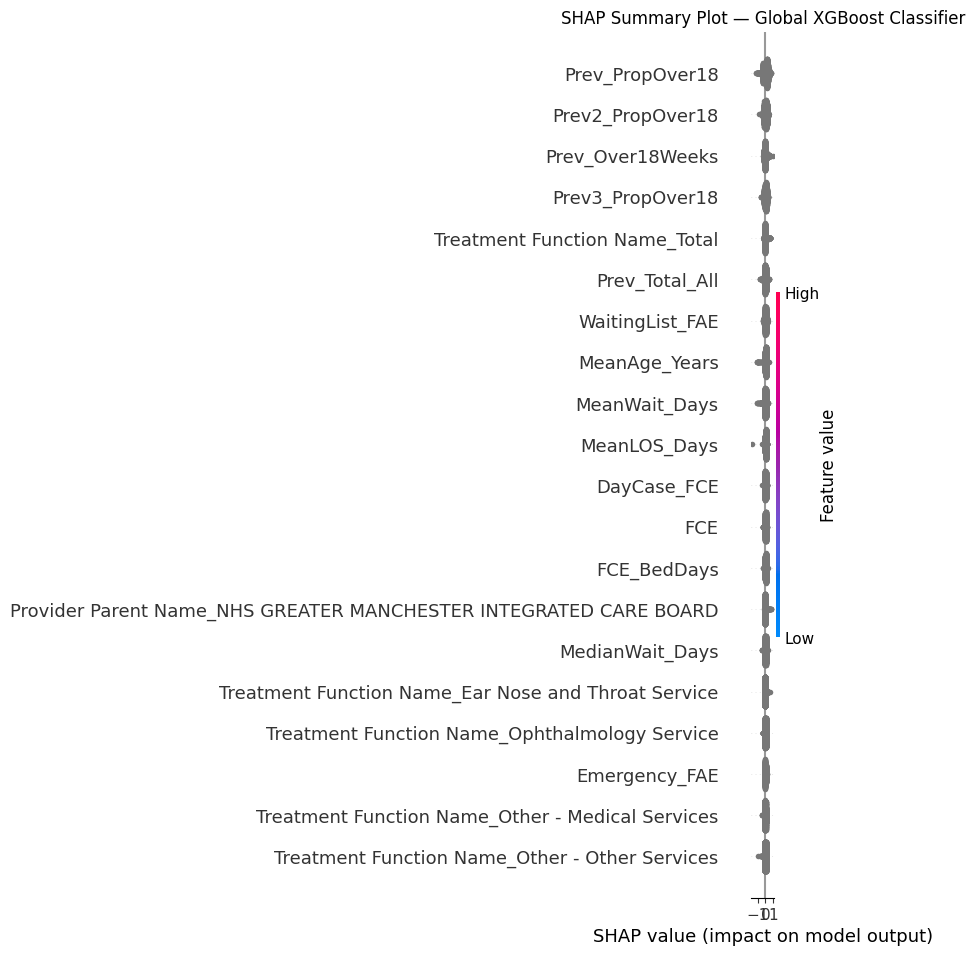

In [155]:
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_shap,
    feature_names=feature_names,
    show=False
)
plt.title("SHAP Summary Plot — Global XGBoost Classifier")
plt.tight_layout()
plt.savefig("figures/shap_summary_global.png", dpi=300)
plt.show()

### **Local SHAP explanation (high-risk provider--specialty--month)**

**Purpose.** Provide a case-level explanation showing how the model arrives at a high-risk classification for a specific observation.

**What this figure shows.**
- A SHAP waterfall plot decomposing the model output into feature contributions for one high-risk case.
- The baseline (expected) prediction and the cumulative effect of influential features.

**How to interpret it.**
- Positive contributions push the prediction toward higher breach risk; negative contributions reduce risk.
- With a preprocessing pipeline, displayed feature values correspond to model inputs (e.g., scaled values), while the direction and relative magnitude remain meaningful.

**Why it matters for this dissertation.**
- Bridges model performance to operational interpretability: planners can understand *why* a particular provider–specialty–month is flagged and which factors are driving the risk signal.

/var/folders/rz/25rj4ln52dvfkhtmtxd64gv80000gn/T/ipykernel_31485/1164083514.py:34: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


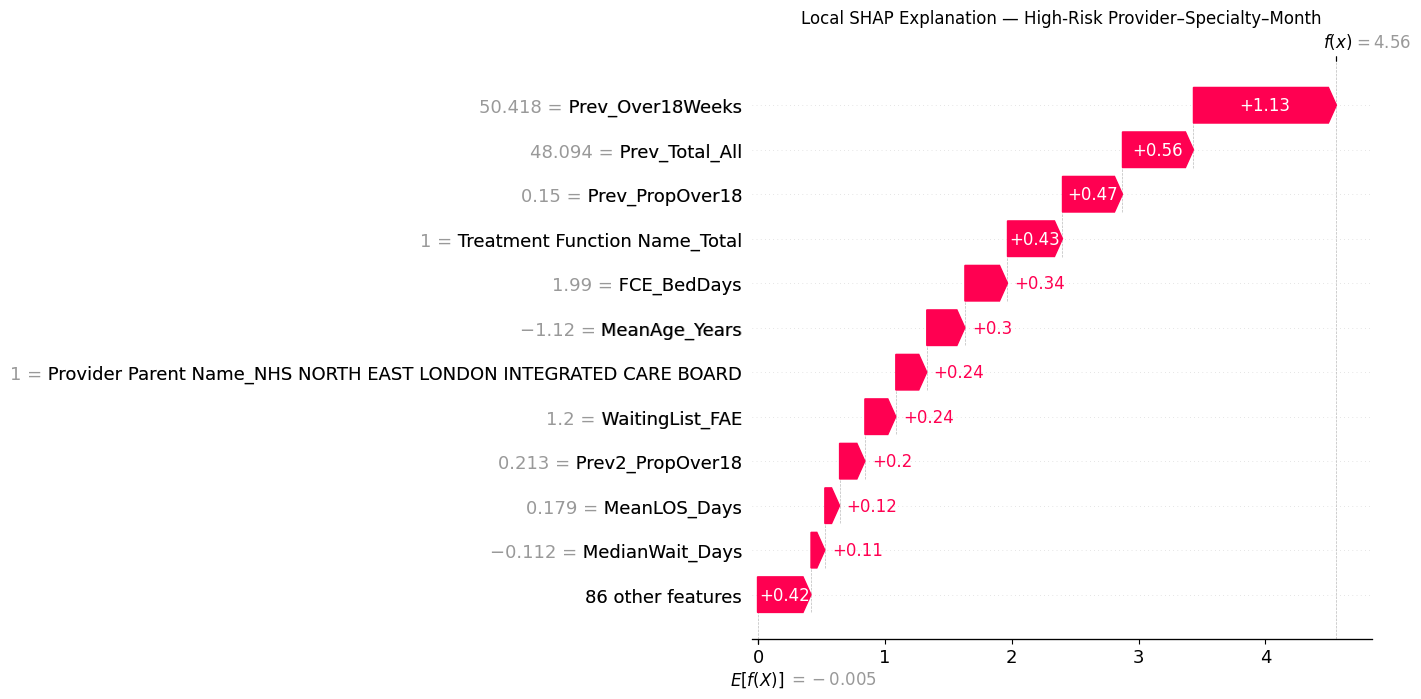

In [156]:
xgb_model = xgb_clf_global.named_steps["model"]
preprocessor = xgb_clf_global.named_steps["preprocess"]

X_test_transformed = preprocessor.transform(X_test_c_global)

explainer = shap.TreeExplainer(xgb_model)

# pick a high-risk case
high_risk_idx = y_proba_global_s.sort_values(ascending=False).index[0]
row_pos = list(X_test_c_global.index).index(high_risk_idx)

X_one = X_test_transformed[row_pos:row_pos+1]
x_one_dense = X_one.toarray().ravel()

shap_values_one = explainer.shap_values(X_one)
if isinstance(shap_values_one, list):
    shap_values_one = shap_values_one[0]
shap_values_one = np.asarray(shap_values_one).ravel()

base_value = explainer.expected_value
if isinstance(base_value, (list, np.ndarray)):
    base_value = np.asarray(base_value).ravel()[0]

exp = shap.Explanation(
    values=shap_values_one,
    base_values=base_value,
    data=x_one_dense,
    feature_names=feature_names
)

plt.figure(figsize=(12, 6))
shap.plots.waterfall(exp, max_display=12, show=False)
plt.title("Local SHAP Explanation — High-Risk Provider–Specialty–Month")
plt.tight_layout()
plt.savefig("figures/shap_local_example.png", dpi=300)
plt.show()


### **Regression Task: Predicting PropOver18 (Breaching Proportion)**

In addition to classifying whether the 18-week target is breached, I also
build **regression models** to predict the continuous outcome `PropOver18`
(i.e. the proportion of patients waiting longer than 18 weeks).

To improve temporal and seasonal modelling, I:

1. Add **seasonality features**:
   - `Quarter`, `Is_Winter`, `Is_Summer`, `Is_Holiday_Month`
2. Add **3-month lag features** for:
   - `Prev3_PropOver18`
   - `Prev3_MeanWait_Days`

Then I:

- Rebuild the train/test split.
- Use a common preprocessing pipeline (StandardScaler + OneHotEncoder).
- Compare three regressors:
  - Ridge Regression (baseline)
  - RandomForestRegressor
  - XGBRegressor

Finally, I summarise MAE, RMSE, and R² for all models.



In [157]:
df = lag_df.copy()

print("Main modelling DataFrame set to df.")
print("Shape:", df.shape)
print("Columns:", list(df.columns))

Main modelling DataFrame set to df.
Shape: (793533, 31)
Columns: ['Provider Org Code', 'Provider Org Name', 'Provider Parent Name', 'Period', 'Treatment Function Code', 'Treatment Function Name', 'Total_All', 'Over18Weeks', 'PropOver18', 'Exceeded18', 'FCE', 'Emergency_FAE', 'WaitingList_FAE', 'MeanWait_Days', 'MedianWait_Days', 'MeanLOS_Days', 'MedianLOS_Days', 'MeanAge_Years', 'DayCase_FCE', 'FCE_BedDays', 'Period_clean', 'Year', 'Month', 'Month_Name', 'Prev_PropOver18', 'Prev_Over18Weeks', 'Prev_Total_All', 'Prev_MeanWait_Days', 'Prev_MeanLOS_Days', 'Prev2_PropOver18', 'Prev3_PropOver18']


In [158]:
print("Adding seasonality features (Quarter, Is_Winter, Is_Summer, Is_Holiday_Month)")


df["Period_clean"] = pd.to_datetime(df["Period_clean"])


df["Quarter"] = df["Period_clean"].dt.quarter.astype("int8")


df["Is_Winter"] = df["Month"].isin([11, 12, 1]).astype("int8")


df["Is_Summer"] = df["Month"].isin([6, 7, 8]).astype("int8")


df["Is_Holiday_Month"] = df["Month"].isin([7, 8, 12]).astype("int8")

print("Seasonality columns added. Preview:")
display(
    df[
        [
            "Period_clean",
            "Year",
            "Month",
            "Month_Name",
            "Quarter",
            "Is_Winter",
            "Is_Summer",
            "Is_Holiday_Month",
        ]
    ].head()
)

print("\nNulls in new seasonality columns:")
print(df[["Quarter", "Is_Winter", "Is_Summer", "Is_Holiday_Month"]].isna().mean())

Adding seasonality features (Quarter, Is_Winter, Is_Summer, Is_Holiday_Month)
Seasonality columns added. Preview:


,Period_clean,Year,Month,Month_Name,Quarter,Is_Winter,Is_Summer,Is_Holiday_Month
40706,2023-04-01,2023,4,April,2,0,0,0
40708,2023-04-01,2023,4,April,2,0,0,0
40710,2023-04-01,2023,4,April,2,0,0,0
40712,2023-04-01,2023,4,April,2,0,0,0
40707,2023-04-01,2023,4,April,2,0,0,0



Nulls in new seasonality columns:
Quarter             0.0
Is_Winter           0.0
Is_Summer           0.0
Is_Holiday_Month    0.0
dtype: float64


In [159]:
print("\nAdding 3-month lag features (Prev3_PropOver18, Prev3_MeanWait_Days)")


df = df.sort_values(["Provider Org Code", "Treatment Function Code", "Period_clean"])


df["Prev3_PropOver18"] = (
    df.groupby(["Provider Org Code", "Treatment Function Code"])["PropOver18"]
      .shift(3)
)

df["Prev3_MeanWait_Days"] = (
    df.groupby(["Provider Org Code", "Treatment Function Code"])["MeanWait_Days"]
      .shift(3)
)

if "Prev_PropOver18" in df.columns:
    df["Prev3_PropOver18"] = df["Prev3_PropOver18"].fillna(df["Prev_PropOver18"])
df["Prev3_PropOver18"] = df["Prev3_PropOver18"].fillna(df["PropOver18"])

if "Prev_MeanWait_Days" in df.columns:
    df["Prev3_MeanWait_Days"] = df["Prev3_MeanWait_Days"].fillna(df["Prev_MeanWait_Days"])
df["Prev3_MeanWait_Days"] = df["Prev3_MeanWait_Days"].fillna(df["MeanWait_Days"])

print("3-month lag columns added. Preview:")
display(
    df[
        [
            "Provider Org Code",
            "Treatment Function Code",
            "Period_clean",
            "PropOver18",
            "Prev_PropOver18",
            "Prev3_PropOver18",
            "MeanWait_Days",
            "Prev_MeanWait_Days",
            "Prev3_MeanWait_Days",
        ]
    ].head(12)
)

print("\nNulls in new lag columns:")
print(df[["Prev3_PropOver18", "Prev3_MeanWait_Days"]].isna().mean())


Adding 3-month lag features (Prev3_PropOver18, Prev3_MeanWait_Days)
3-month lag columns added. Preview:


,Provider Org Code,Treatment Function Code,Period_clean,PropOver18,Prev_PropOver18,Prev3_PropOver18,MeanWait_Days,Prev_MeanWait_Days,Prev3_MeanWait_Days
40706,A0C5S,C_130,2023-04-01,0.022472,0.053571,0.053571,19.76559,19.76559,19.76559
40708,A0C5S,C_130,2023-04-01,0.181818,0.022472,0.022472,19.76559,19.76559,19.76559
40710,A0C5S,C_130,2023-04-01,0.000000,0.181818,0.181818,19.76559,19.76559,19.76559
40712,A0C5S,C_130,2023-04-01,0.000000,0.000000,0.022472,19.76559,19.76559,19.76559
571843,A0C5S,C_130,2023-05-01,0.050847,0.000000,0.181818,19.76559,19.76559,19.76559
571845,A0C5S,C_130,2023-05-01,0.000000,0.050847,0.000000,19.76559,19.76559,19.76559
571847,A0C5S,C_130,2023-05-01,0.032258,0.000000,0.000000,19.76559,19.76559,19.76559
571849,A0C5S,C_130,2023-05-01,0.000000,0.032258,0.050847,19.76559,19.76559,19.76559
571851,A0C5S,C_130,2023-05-01,0.142857,0.000000,0.000000,19.76559,19.76559,19.76559
571853,A0C5S,C_130,2023-05-01,0.000000,0.142857,0.032258,19.76559,19.76559,19.76559



Nulls in new lag columns:
Prev3_PropOver18       0.0
Prev3_MeanWait_Days    0.0
dtype: float64


In [160]:
lag_df = df.copy()

print("lag_df updated with new seasonality + 3-month lag features.")
print("New shape:", lag_df.shape)
print("New columns added:",
      [c for c in lag_df.columns if c in ["Quarter", "Is_Winter", "Is_Summer",
                                          "Is_Holiday_Month",
                                          "Prev3_PropOver18", "Prev3_MeanWait_Days"]])

lag_df updated with new seasonality + 3-month lag features.
New shape: (793533, 36)
New columns added: ['Prev3_PropOver18', 'Quarter', 'Is_Winter', 'Is_Summer', 'Is_Holiday_Month', 'Prev3_MeanWait_Days']


In [161]:
print("\nRebuilding train/test split and feature matrices with new features")

target_class = "Exceeded18"
target_reg   = "PropOver18"

numeric_features = [
    "Total_All",
    "Over18Weeks",
    "FCE",
    "Emergency_FAE",
    "WaitingList_FAE",
    "MeanWait_Days",
    "MedianWait_Days",
    "MeanLOS_Days",
    "MedianLOS_Days",
    "MeanAge_Years",
    "DayCase_FCE",
    "FCE_BedDays",
    "Prev_PropOver18",
    "Prev_Over18Weeks",
    "Prev_Total_All",
    "Prev_MeanWait_Days",
    "Prev_MeanLOS_Days",
    "Prev3_PropOver18",      
    "Prev3_MeanWait_Days",   
    "Year",
    "Month",
    "Quarter",               
    "Is_Winter",             
    "Is_Summer",             
    "Is_Holiday_Month",      
]

categorical_features = [
    "Provider Org Code",
    "Provider Org Name",
    "Provider Parent Name",
    "Treatment Function Code",
    "Treatment Function Name",
    "Month_Name",
]

X = lag_df[numeric_features + categorical_features]
y_class = lag_df[target_class]
y_reg   = lag_df[target_reg]


train_df, test_df = train_test_split(
    lag_df,
    test_size=0.20,
    random_state=42,
    stratify=lag_df[target_class]
)


X_train_c = train_df[numeric_features + categorical_features]
X_test_c  = test_df[numeric_features + categorical_features]
y_train_c = train_df[target_class]
y_test_c  = test_df[target_class]

X_train_r = train_df[numeric_features + categorical_features]
X_test_r  = test_df[numeric_features + categorical_features]
y_train_r = train_df[target_reg]
y_test_r  = test_df[target_reg]

print("Shapes:")
print("X_train_c:", X_train_c.shape, "y_train_c:", y_train_c.shape)
print("X_test_c :", X_test_c.shape,  "y_test_c :", y_test_c.shape)
print("X_train_r:", X_train_r.shape, "y_train_r:", y_train_r.shape)
print("X_test_r :", X_test_r.shape,  "y_test_r :", y_test_r.shape)


Rebuilding train/test split and feature matrices with new features
Shapes:
X_train_c: (634826, 31) y_train_c: (634826,)
X_test_c : (158707, 31) y_test_c : (158707,)
X_train_r: (634826, 31) y_train_r: (634826,)
X_test_r : (158707, 31) y_test_r : (158707,)


In [162]:
preprocessor_reg = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

print("Regression preprocessor defined.")
print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))

Regression preprocessor defined.
Numeric features: 25
Categorical features: 6


In [163]:
def evaluate_regressor(name, model, X_train, y_train, X_test, y_test):
    """Fit a regression model, time it, and print MAE / RMSE / R²."""
    print(f"\n===== {name} =====")
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    print(f"Training time: {train_time:.2f} seconds")

    preds = model.predict(X_test)

    mae  = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2   = r2_score(y_test, preds)

    print(f"MAE : {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²  : {r2:.4f}")

    return {"name": name, "mae": mae, "rmse": rmse, "r2": r2, "train_time": train_time}

### **Ridge Regressor**

In [164]:
ridge_reg = Pipeline(
    steps=[
        ("preprocess", preprocessor_reg),
        ("model", Ridge(alpha=1.0, random_state=42))
    ]
)

ridge_results = evaluate_regressor(
    "Ridge Regression (baseline)",
    ridge_reg,
    X_train_r,
    y_train_r,
    X_test_r,
    y_test_r,
)


===== Ridge Regression (baseline) =====
Training time: 7.30 seconds
MAE : 0.2818
RMSE: 0.3482
R²  : 0.1415


### **Random Forest Regressor**

In [165]:
rf_reg = Pipeline(
    steps=[
        ("preprocess", preprocessor_reg),
        ("model", RandomForestRegressor(
            n_estimators=300,   # reduced a bit for speed
            max_depth=18,
            min_samples_leaf=5,
            n_jobs=-1,
            random_state=42
        ))
    ]
)

rf_results = evaluate_regressor(
    "RandomForest Regressor",
    rf_reg,
    X_train_r,
    y_train_r,
    X_test_r,
    y_test_r,
)


===== RandomForest Regressor =====
Training time: 1025.48 seconds
MAE : 0.0072
RMSE: 0.0290
R²  : 0.9940


### **XGBoost Regressor**

In [166]:
xgb_reg = Pipeline(
    steps=[
        ("preprocess", preprocessor_reg),
        ("model", XGBRegressor(
            n_estimators=600,
            max_depth=8,
            learning_rate=0.04,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=2.0,
            reg_alpha=1.0,
            gamma=0.1,
            objective="reg:squarederror",
            tree_method="auto",   # change to "gpu_hist" if GPU is enabled
            random_state=42
        ))
    ]
)

xgb_results = evaluate_regressor(
    "XGBoost Regressor",
    xgb_reg,
    X_train_r,
    y_train_r,
    X_test_r,
    y_test_r,
)


===== XGBoost Regressor =====
Training time: 6.60 seconds
MAE : 0.0072
RMSE: 0.0137
R²  : 0.9987


### **Results Comparison of Regressors**

In [167]:
all_results = pd.DataFrame([ridge_results, rf_results, xgb_results])
display(all_results.sort_values("r2", ascending=False))

,name,mae,rmse,r2,train_time
2,XGBoost Regressor,0.007182,0.013664,0.998678,6.602237
1,RandomForest Regressor,0.007208,0.029040,0.994027,1025.481210
0,Ridge Regression (baseline),0.281790,0.348152,0.141542,7.295437


In [168]:
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True)

print("Saving figures to:", FIG_DIR.resolve())

Saving figures to: /Users/saadahsan/Downloads/dissertation/figures


## **Figures and Plots**

### **RTT breach prevalence by specialty (Top 15 by volume)**

**Purpose.** Summarise which clinical specialties contribute most to breach risk in the evaluation set, focusing on specialties with the largest number of observations.

**What this figure shows.**
- The breach rate (mean of `Exceeded18`) for the 15 busiest specialties.
- A quick “where is the problem concentrated?” view.

**How to interpret it.**
- Higher bars indicate specialties that are structurally more likely to breach.
- Because we restrict to the most common specialties, the ranking is not dominated by small-sample noise.


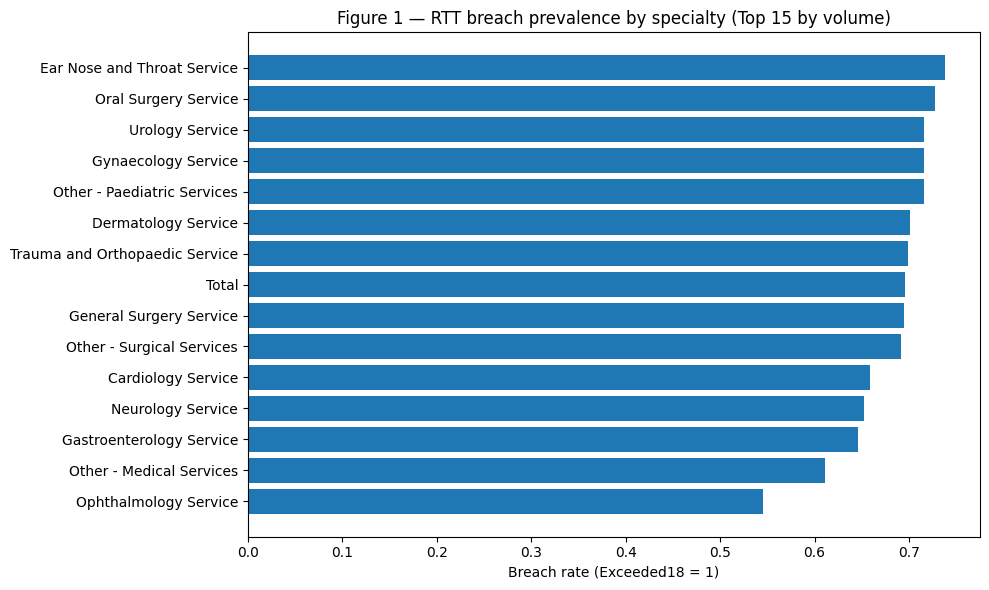

In [169]:
# Breach rate by specialty (top 15 by volume)
tmp = test_df.copy()
spec_stats = (
    tmp.groupby("Treatment Function Name")
       .agg(n=("Exceeded18","size"), breach_rate=("Exceeded18","mean"))
       .sort_values("n", ascending=False)
       .head(15)
       .sort_values("breach_rate", ascending=True)
)

plt.figure(figsize=(10, 6))
plt.barh(spec_stats.index, spec_stats["breach_rate"].values)
plt.xlabel("Breach rate (Exceeded18 = 1)")
plt.title("Figure 1 — RTT breach prevalence by specialty (Top 15 by volume)")
plt.tight_layout()
plt.savefig(FIG_DIR/"fig1_breach_rate_by_specialty.png", dpi=300)
plt.show()

### **Distribution of PropOver18 by breach status**

**Purpose.** Show how the continuous outcome (`PropOver18`) differs between “breach” and “non-breach” cases, and visually justify the classification target definition.

**What this figure shows.**
- The distribution of `PropOver18` for `Exceeded18=0` versus `Exceeded18=1`.
- The 10% breach threshold (horizontal line) as the operational decision boundary.

**How to interpret it.**
- Clear separation indicates the threshold is meaningful and not arbitrary.
- Overlap near 10% highlights borderline cases where probabilistic modelling is helpful.



/var/folders/rz/25rj4ln52dvfkhtmtxd64gv80000gn/T/ipykernel_31485/3005640928.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


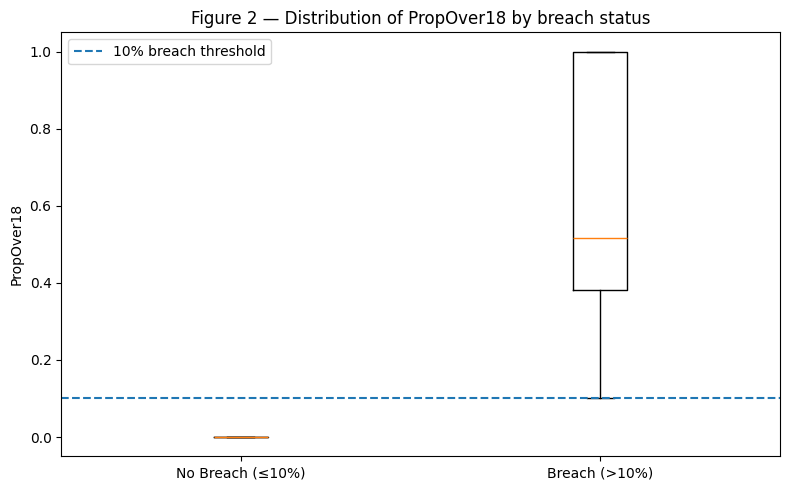

In [170]:
plt.figure(figsize=(8, 5))

data0 = test_df.loc[test_df["Exceeded18"] == 0, "PropOver18"]
data1 = test_df.loc[test_df["Exceeded18"] == 1, "PropOver18"]

plt.boxplot(
    [data0, data1],
    labels=["No Breach (≤10%)", "Breach (>10%)"],
    showfliers=False
)

plt.axhline(0.10, linestyle="--", label="10% breach threshold")
plt.ylabel("PropOver18")
plt.title("Figure 2 — Distribution of PropOver18 by breach status")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "fig2_propOver18_by_breach_status.png", dpi=300)
plt.show()

###  **Cumulative risk curve for RTT waiting-time breaches (CDF)**

**Purpose.** Quantify how RTT pressure accumulates across thresholds and motivate the choice of the 10% breach cut-off using an empirical distribution view.

**What this figure shows.**
- The empirical cumulative distribution function (CDF) of `PropOver18`.
- A vertical reference line at 0.10 (10%), indicating where the breach threshold sits relative to the overall distribution.

**How to interpret it.**
- The y-value at 0.10 gives the proportion of observations at or below the threshold.
- One minus that value gives the proportion exceeding 10% (i.e., breach prevalence).


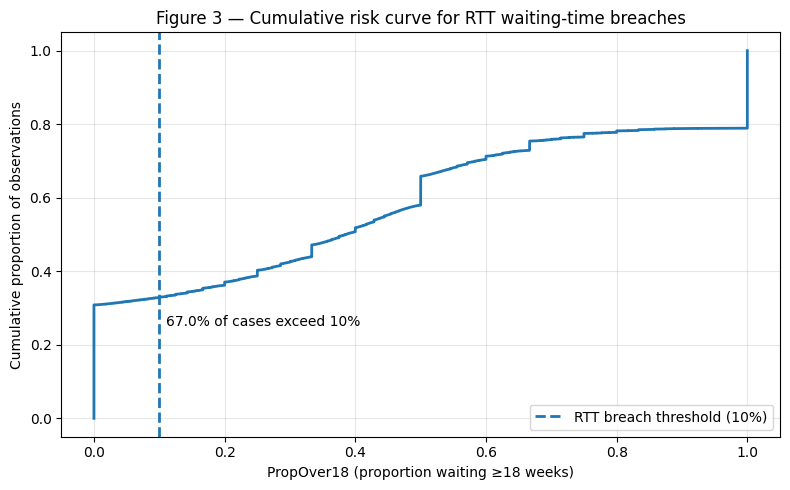

In [171]:
# ============================================================
# Figure 2 — Cumulative Risk Curve (CDF of PropOver18)
# ============================================================

vals = test_df["PropOver18"].dropna().values

# Sort values for empirical CDF
vals_sorted = np.sort(vals)
cdf = np.arange(1, len(vals_sorted) + 1) / len(vals_sorted)

plt.figure(figsize=(8, 5))
plt.plot(vals_sorted, cdf, linewidth=2)

# Highlight the 10% RTT breach threshold
plt.axvline(
    0.10,
    linestyle="--",
    linewidth=2,
    label="RTT breach threshold (10%)"
)

# Optional annotation
pct_above_10 = (vals_sorted > 0.10).mean() * 100
plt.text(
    0.11,
    0.25,
    f"{pct_above_10:.1f}% of cases exceed 10%",
    fontsize=10
)

plt.xlabel("PropOver18 (proportion waiting ≥18 weeks)")
plt.ylabel("Cumulative proportion of observations")
plt.title("Figure 3 — Cumulative risk curve for RTT waiting-time breaches")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig(FIG_DIR / "fig2_cdf_propOver18.png", dpi=300)
plt.show()

### **Seasonality of RTT pressure (mean PropOver18 by month)**

**Purpose.** Visualise whether RTT pressure varies systematically over the year, supporting the inclusion of seasonality features (e.g., holiday and winter indicators).

**What this figure shows.**
- Monthly average `PropOver18` across the financial-year months.
- Potential dips/spikes associated with holiday periods and winter pressures.

**How to interpret it.**
- Peaks suggest months where system pressure is persistently higher.
- Dips indicate periods of reduced elective throughput or backlog dynamics.


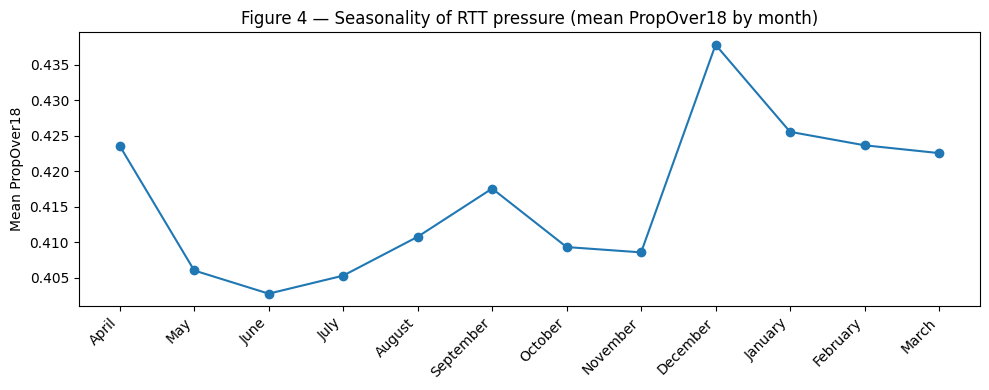

In [172]:
# Ensure month order is Apr→Mar for FY 2023–24
month_order = ["April","May","June","July","August","September","October","November",
               "December","January","February","March"]

season = (
    test_df.groupby("Month_Name")["PropOver18"].mean()
    .reindex(month_order)
)

plt.figure(figsize=(10, 4))
plt.plot(season.index, season.values, marker="o")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean PropOver18")
plt.title("Figure 4 — Seasonality of RTT pressure (mean PropOver18 by month)")
plt.tight_layout()
plt.savefig(FIG_DIR/"fig3_seasonality_mean_propOver18.png", dpi=300)
plt.show()

### **ROC curves (Global vs Hybrid)**

**Purpose.** Compare the ranking performance of the global classifier versus the hybrid ensemble across all possible thresholds.

**What this figure shows.**
- ROC curves for the global and hybrid models.
- Area under the ROC curve (AUC) summarising threshold-independent discrimination.

**How to interpret it.**
- Curves closer to the top-left indicate better discrimination.
- AUC measures how well the model ranks breach vs non-breach cases irrespective of the chosen operating threshold.


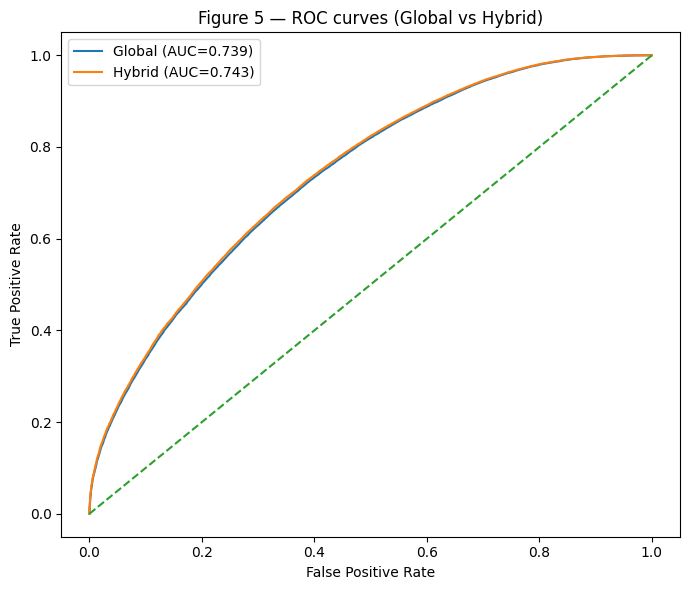

In [173]:
# Global vs Hybrid ROC
fpr_g, tpr_g, _ = roc_curve(y_true, y_proba_global_s)
fpr_e, tpr_e, _ = roc_curve(y_true, y_proba_ens)

auc_g = auc(fpr_g, tpr_g)
auc_e = auc(fpr_e, tpr_e)

plt.figure(figsize=(7, 6))
plt.plot(fpr_g, tpr_g, label=f"Global (AUC={auc_g:.3f})")
plt.plot(fpr_e, tpr_e, label=f"Hybrid (AUC={auc_e:.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Figure 5 — ROC curves (Global vs Hybrid)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR/"fig4_roc_global_vs_hybrid.png", dpi=300)
plt.show()

### **Precision-Recall curves (Global vs Hybrid)**

**Purpose.** Evaluate performance in terms of the precision–recall trade-off, which is often more informative than ROC when the positive class is common or when false positives/false negatives have different operational costs.

**What this figure shows.**
- Precision–recall curves for global and hybrid models.

**How to interpret it.**
- Higher curves indicate that for a given recall (sensitivity), the model achieves better precision.
- Useful when prioritising “catch most breaches” while controlling unnecessary alerts.


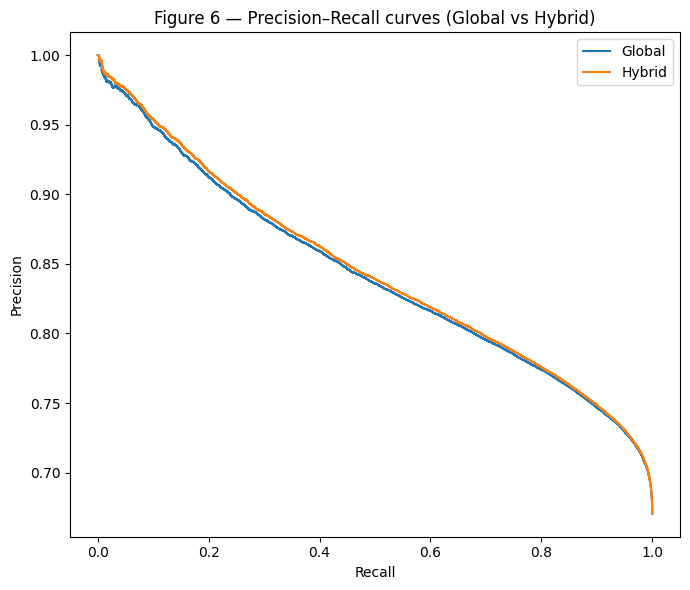

In [174]:
prec_g, rec_g, _ = precision_recall_curve(y_true, y_proba_global_s)
prec_e, rec_e, _ = precision_recall_curve(y_true, y_proba_ens)

plt.figure(figsize=(7, 6))
plt.plot(rec_g, prec_g, label="Global")
plt.plot(rec_e, prec_e, label="Hybrid")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Figure 6 — Precision–Recall curves (Global vs Hybrid)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR/"fig5_pr_global_vs_hybrid.png", dpi=300)
plt.show()

### **Threshold scan for the hybrid ensemble**

**Purpose.** Select an operating threshold that reflects the practical objective (e.g., high recall for early warning) rather than relying on the default 0.5 cut-off.

**What this figure shows.**
- Accuracy, precision, and recall as functions of the classification threshold.
- A vertical marker at the chosen optimal threshold.

**How to interpret it.**
- Lower thresholds typically increase recall but reduce precision.
- The selected threshold represents a deliberate trade-off aligned with operational priorities.


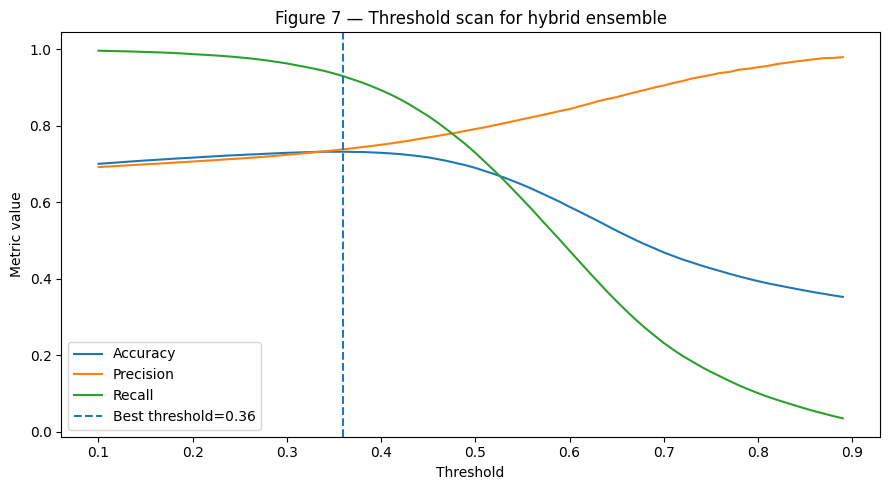

In [175]:
thr = np.array([i/100 for i in range(10, 90)])
accs, precs, recs = [], [], []

for t in thr:
    yp = (y_proba_ens >= t).astype(int)
    accs.append(accuracy_score(y_true, yp))
    precs.append(precision_score(y_true, yp, zero_division=0))
    recs.append(recall_score(y_true, yp, zero_division=0))

accs = np.array(accs); precs = np.array(precs); recs = np.array(recs)

plt.figure(figsize=(9, 5))
plt.plot(thr, accs, label="Accuracy")
plt.plot(thr, precs, label="Precision")
plt.plot(thr, recs, label="Recall")
plt.axvline(best_thresh, linestyle="--", label=f"Best threshold={best_thresh:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Metric value")
plt.title("Figure 7 — Threshold scan for hybrid ensemble")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR/"fig6_threshold_scan.png", dpi=300)
plt.show()

### **Confusion matrix (final hybrid model)**

**Purpose.** Provide a concrete, count-based summary of final classification outcomes at the chosen threshold.

**What this figure shows.**
- True positives, false positives, true negatives, and false negatives for the hybrid ensemble.
- A direct view of the types of errors the model makes.

**How to interpret it.**
- False negatives correspond to missed breach risks (often the most costly error operationally).
- False positives correspond to “alerts” that may waste attention or resources.


<Figure size 600x500 with 0 Axes>

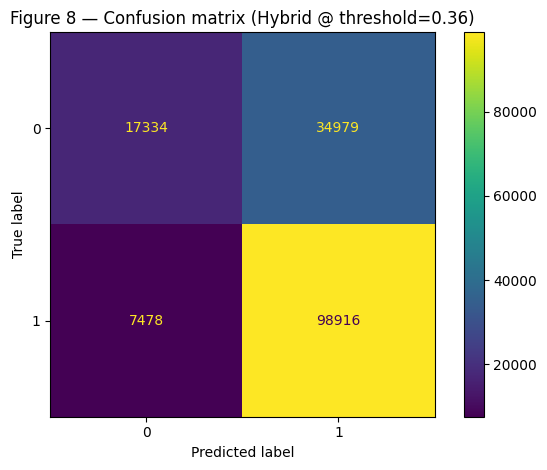

In [176]:
cm = confusion_matrix(y_true, y_pred_best)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(6, 5))
disp.plot(values_format="d")
plt.title(f"Figure 8 — Confusion matrix (Hybrid @ threshold={best_thresh:.2f})")
plt.tight_layout()
plt.savefig(FIG_DIR/"fig7_confusion_matrix_best_threshold.png", dpi=300)
plt.show()

### **Regression performance (Predicted vs Actual PropOver18)**

**Purpose.** Evaluate how well the regression model estimates the continuous RTT pressure outcome, complementing the binary breach classifier.

**What this figure shows.**
- Scatter plot of predicted vs actual `PropOver18` on the test set.
- A diagonal reference line (perfect prediction).

**How to interpret it.**
- Points close to the diagonal indicate accurate estimates.
- Systematic deviations reveal where the model under- or over-predicts pressure (often due to unobserved operational factors).

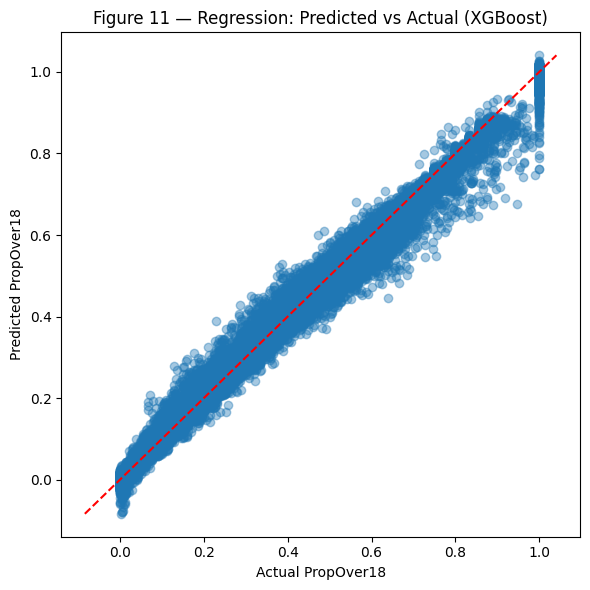

In [177]:
y_pred_xgb = xgb_reg.predict(X_test_r)
plt.figure(figsize=(6, 6))
plt.scatter(y_test_r, y_pred_xgb, alpha=0.4)
lo = float(min(y_test_r.min(), y_pred_xgb.min()))
hi = float(max(y_test_r.max(), y_pred_xgb.max()))
plt.plot([lo, hi], [lo, hi], linestyle="--",color='red',)
plt.xlabel("Actual PropOver18")
plt.ylabel("Predicted PropOver18")
plt.title("Figure 11 — Regression: Predicted vs Actual (XGBoost)")
plt.tight_layout()
plt.savefig(FIG_DIR/"fig10_regression_pred_vs_actual_xgb.png", dpi=300)
plt.show()